<a href="https://colab.research.google.com/github/sueprim/stock_predict_model/blob/main/v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1011 - val_loss: 0.0111
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 

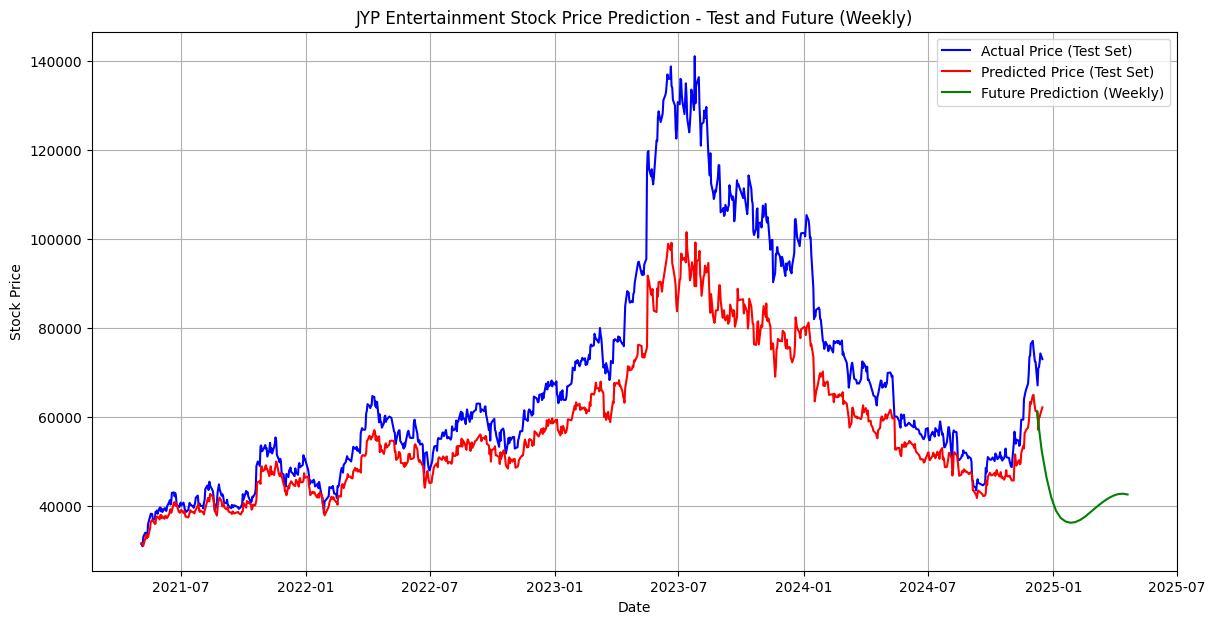

In [3]:
# 필요한 라이브러리 설치
!pip install yfinance matplotlib scikit-learn tensorflow

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import timedelta
import matplotlib.dates as mdates

# 1. 데이터 다운로드
stock_symbol = '035900.KQ'  # JYP 엔터테인먼트 KOSDAQ 코드
today = pd.Timestamp.today().strftime('%Y-%m-%d')
data = yf.download(stock_symbol, start='2000-01-01', end=today)

# 'Close' 가격만 사용
data = data[['Close']]
data.dropna(inplace=True)

# 2. 데이터 전처리
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

time_step = 60
train_data_len = int(len(scaled_data)*0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. 새로운 모델 아키텍처 정의
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 4. 모델 학습
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

# 5. 테스트 데이터 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. 미래 예측 (2024-12 ~ 2025-05, 주 단위 예측)
# 주단위 예측을 위해 대략 20주 정도 예측
future_steps = 20  # 약 20주
future_predictions = []
current_input = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(future_steps):
    next_pred = model.predict(current_input)
    future_predictions.append(next_pred[0, 0])
    current_input[:, :-1, :] = current_input[:, 1:, :]
    current_input[:, -1, :] = next_pred

# 역정규화
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 미래 날짜를 주 단위로 생성
future_dates = pd.date_range(start='2024-12-05', periods=future_steps, freq='W')
test_index = data.index[train_data_len+time_step:]

# 7. 테스트 결과와 미래 예측 결과를 한 그래프에 표시
plt.figure(figsize=(14,7))
plt.plot(test_index, y_test_scaled, label='Actual Price (Test Set)', color='blue')
plt.plot(test_index, predictions, label='Predicted Price (Test Set)', color='red')

# 미래 예측 결과를 동일한 그림에 이어붙이기
plt.plot(future_dates, future_predictions, label='Future Prediction (Weekly)', linestyle='-', color='green')

plt.title('JYP Entertainment Stock Price Prediction - Test and Future (Weekly)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()